# FISH - Data interpretation - A Python interactive notebook to interpret FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.

```

## Importing libraries

In [1]:
import sys
import matplotlib.pyplot as plt 
from  matplotlib.ticker import FuncFormatter
import numpy as np 
import pandas as pd
import pathlib
import warnings
import glob
import seaborn as sns
import zipfile
import shutil
import scipy.stats as stats
import os
warnings.filterwarnings("ignore")

## Defining paths

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa
# Local folder path
local_folder_path = pathlib.Path().absolute().joinpath('temp_zip_analyses')
local_folder_path
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
# Connection to munsky-nas
path_to_config_file = desktop_path.joinpath('config.yml')
share_name = 'share'

# creating a folder to store all plots
destination_folder = pathlib.Path().absolute().joinpath('results', 'data_Huy')
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder) 

In [3]:
psf_z=350                # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=160               # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers
voxel_size_z=500         # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=160        # Microscope conversion px to nanometers in the xy axis.
scale = np.array ([ voxel_size_z/psf_z, voxel_size_yx/psf_yx, voxel_size_yx/psf_yx ])

list_timepoints = [0,18,300]
list_thresholds_intensity =[400,450,500,550]
list_thresholds_distance=[1,2,3]

## List of folders to process

In [4]:
def Huy_data(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim',
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM' )
    list_labels = [ 'woSTM','18minTPL_5uM','5hTPL_5uM']
    plot_title_suffix= "MS2_CY5"
    mandatory_substring = mandatory_substring      #'nuc_70__cyto_0__psfz_350__psfyx_160__ts_400_400'
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring

----

# Running the codes

----

In [5]:
substrings =[
    'nuc_70__cyto_0__psfz_350__psfyx_160__ts_400_400',
    'nuc_70__cyto_0__psfz_350__psfyx_160__ts_450_450',
    'nuc_70__cyto_0__psfz_350__psfyx_160__ts_500_500',
    'nuc_70__cyto_0__psfz_350__psfyx_160__ts_550_550' ]

## Connecting to NAS and extracting data

In [6]:
list_df_paths=[]
list_df_names=[]
counter_dataframes =0
plot_title_suffix= "MS2_CY5"
for k, ts_distance in enumerate(list_thresholds_distance):
    for j,mandatory_substring in enumerate(substrings):
        # Iterating for each time point (experimental condition)
        for i,tp in enumerate (list_timepoints):
            df_name = plot_title_suffix+'_time_'+str(tp)+ '_int_'+str(list_thresholds_intensity[j])+ '_dist_'+str(ts_distance)
            df_path=pathlib.Path().absolute().joinpath(destination_folder,df_name +'.csv')
            list_df_paths.append(df_path)
            list_df_names.append(df_name)
            counter_dataframes+=1
# Loading all dataframes in a dictionary
dic_dataframes = {}
for df_index, df_name in enumerate (list_df_names):
    dic_dataframes[df_name] = pd.read_csv(list_df_paths[df_index])


In [7]:
matrix_number_spots_time_0 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_distance)) )
matrix_both_by_total_time_0 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_distance)) )
for int, ts_intensity in enumerate(list_thresholds_intensity):
    for d, ts_distance in enumerate(list_thresholds_distance):
        df_name_loop = 'MS2_CY5_time_0_int_'+str(ts_intensity)+'_dist_'+str(ts_distance)
        matrix_both_by_total_time_0[int, d] =   np.round(
                                                np.mean (   
                                                np.nan_to_num(
                                                np.divide( dic_dataframes[df_name_loop]['num_0_1'].values ,  dic_dataframes[df_name_loop]['total'].values)
                                                )
                                                )
                                                ,2)
        matrix_number_spots_time_0[int, d] =np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)
matrix_number_spots_time_0
matrix_both_by_total_time_0

array([[0.08, 0.31, 0.46],
       [0.08, 0.33, 0.47],
       [0.08, 0.33, 0.48],
       [0.08, 0.33, 0.48]])

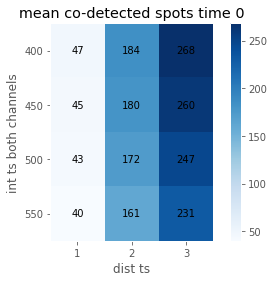

In [8]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_number_spots_time_0,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_number_spots_time_0.astype('int')):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(list_thresholds_distance)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('dist ts')
ax.set_ylabel('int ts both channels')
ax.set_title('mean co-detected spots time 0')
fig.colorbar(img)
plt.grid(None)
plt.show()

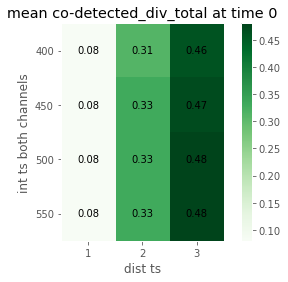

In [9]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_both_by_total_time_0,cmap='Greens')
for (j,i),label in np.ndenumerate(matrix_both_by_total_time_0):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(list_thresholds_distance)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('dist ts')
ax.set_ylabel('int ts both channels')
ax.set_title(r'mean co-detected_div_total at time 0')
fig.colorbar(img)
plt.grid(None)
plt.show()

In [10]:
matrix_number_spots_tme_18 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_distance)) )
matrix_both_by_total_time_18 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_distance)) )

for int, ts_intensity in enumerate(list_thresholds_intensity):
    for d, ts_distance in enumerate(list_thresholds_distance):
        df_name_loop = 'MS2_CY5_time_18_int_'+str(ts_intensity)+'_dist_'+str(ts_distance)
        matrix_both_by_total_time_18[int, d] =   np.round(
                                                np.mean (   
                                                np.nan_to_num(
                                                np.divide( dic_dataframes[df_name_loop]['num_0_1'].values ,  dic_dataframes[df_name_loop]['total'].values)
                                                )
                                                )
                                                ,2)
        matrix_number_spots_tme_18[int, d] = np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)
matrix_number_spots_tme_18

array([[ 28., 112., 169.],
       [ 23.,  96., 142.],
       [ 19.,  79., 116.],
       [ 15.,  64.,  94.]])

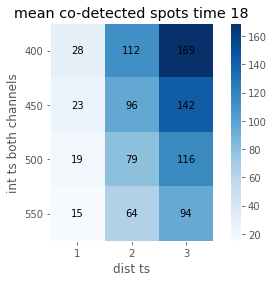

In [11]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_number_spots_tme_18,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_number_spots_tme_18.astype('int')):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(list_thresholds_distance)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('dist ts')
ax.set_ylabel('int ts both channels')
ax.set_title('mean co-detected spots time 18')
fig.colorbar(img)
plt.grid(None)
plt.show()

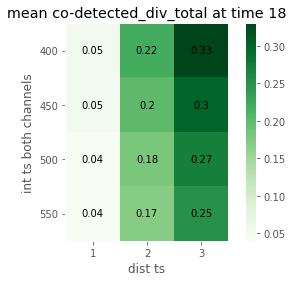

In [12]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_both_by_total_time_18,cmap='Greens')
for (j,i),label in np.ndenumerate(matrix_both_by_total_time_18):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(list_thresholds_distance)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('dist ts')
ax.set_ylabel('int ts both channels')
ax.set_title(r'mean co-detected_div_total at time 18')
fig.colorbar(img)
plt.grid(None)
plt.show()

In [13]:
matrix_number_spots_tme_300 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_distance)) )
matrix_both_by_total_time_300 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_distance)) )

for int, ts_intensity in enumerate(list_thresholds_intensity):
    for d, ts_distance in enumerate(list_thresholds_distance):
        df_name_loop = 'MS2_CY5_time_300_int_'+str(ts_intensity)+'_dist_'+str(ts_distance)
        matrix_both_by_total_time_300[int, d] =   np.round(
                                                np.mean (   
                                                np.nan_to_num(
                                                np.divide( dic_dataframes[df_name_loop]['num_0_1'].values ,  dic_dataframes[df_name_loop]['total'].values)
                                                )
                                                )
                                                ,2)
        matrix_number_spots_tme_300[int, d] = np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)
matrix_number_spots_tme_300

array([[ 2.,  6., 10.],
       [ 1.,  3.,  5.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  1.]])

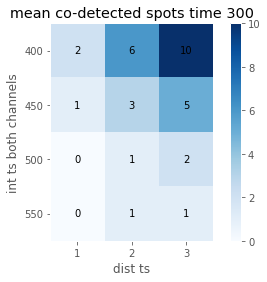

In [14]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_number_spots_tme_300,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_number_spots_tme_300.astype('int')):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(list_thresholds_distance)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('dist ts')
ax.set_ylabel('int ts both channels')
ax.set_title('mean co-detected spots time 300')
fig.colorbar(img)
plt.grid(None)
plt.show()

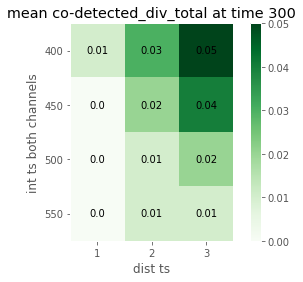

In [15]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_both_by_total_time_300,cmap='Greens')
for (j,i),label in np.ndenumerate(matrix_both_by_total_time_300):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(list_thresholds_distance)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('dist ts')
ax.set_ylabel('int ts both channels')
ax.set_title(r'mean co-detected_div_total at time 300')
fig.colorbar(img)
plt.grid(None)
plt.show()